
== Fold 1 ==
Fold 1 RMSE: 1337468.66 | R²: 0.6461


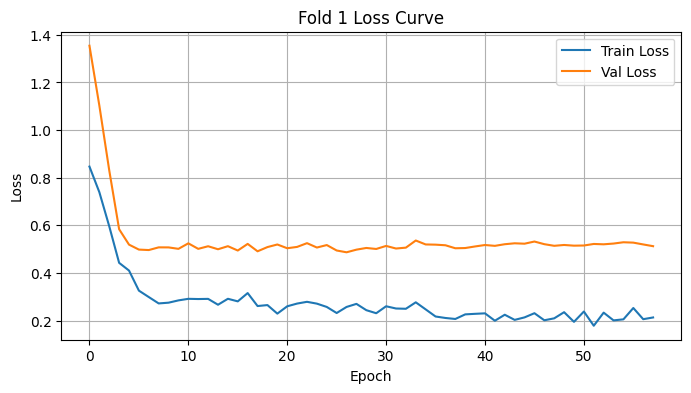


== Fold 2 ==
Fold 2 RMSE: 1162241.18 | R²: 0.6805


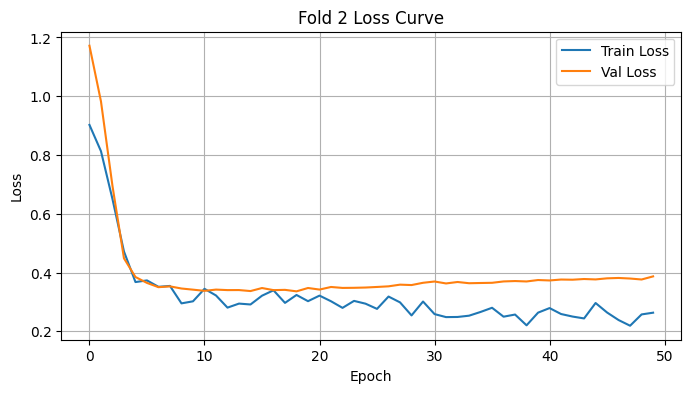


== Fold 3 ==
Fold 3 RMSE: 972256.62 | R²: 0.4111


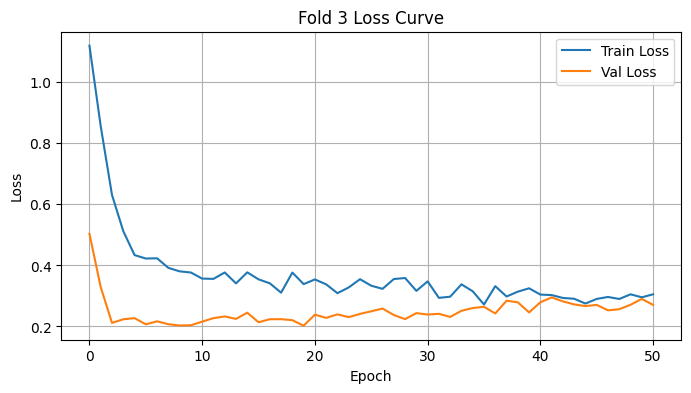


== Fold 4 ==
Fold 4 RMSE: 930632.04 | R²: 0.6904


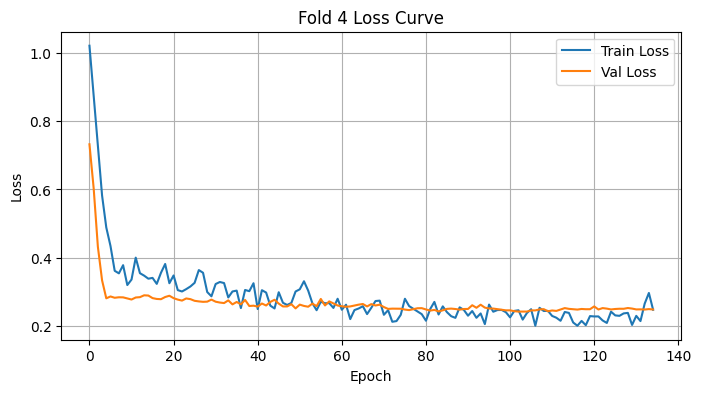


== Fold 5 ==
Fold 5 RMSE: 1005707.66 | R²: 0.7120


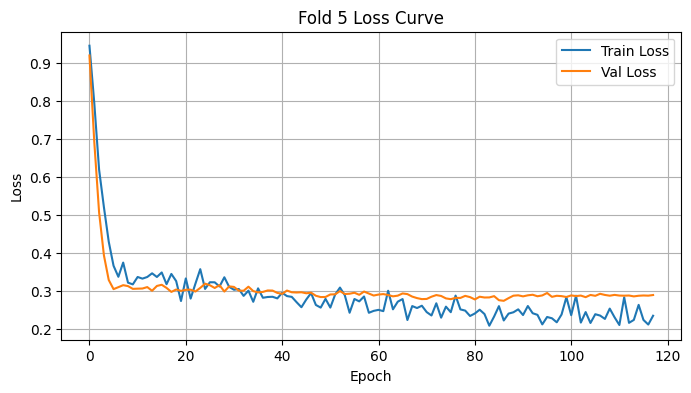


==== Final Results ====
Average R² Score: 0.6280 (±0.1105)
Best R² was 0.7120 in Fold 5


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

data = pd.read_csv("Housing.csv")
data.columns = data.columns.str.strip().str.lower().str.replace(" ", "_")

data['area_x_bedrooms'] = data['area'] * data['bedrooms']
data['area_x_bathrooms'] = data['area'] * data['bathrooms']

binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
data[binary_cols] = data[binary_cols].apply(lambda x: x.map({'yes': 1, 'no': 0}))
data = pd.get_dummies(data, columns=['furnishingstatus'], drop_first=True)

features = data.drop('price', axis=1)
target = data['price'].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
features = scaler_X.fit_transform(features)
target = scaler_y.fit_transform(target)

torch.manual_seed(42)
np.random.seed(42)

class EnhancedHousingModel(nn.Module):
    def __init__(self, input_size):
        super(EnhancedHousingModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

def run_kfold_training(X, y, folds=5, max_epochs=800):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    fold_results = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        print(f"\n== Fold {fold_idx} ==")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

        dataset = TensorDataset(X_train_tensor, y_train_tensor)
        loader = DataLoader(dataset, batch_size=32, shuffle=True)

        model = EnhancedHousingModel(X.shape[1])
        optimizer = optim.AdamW(model.parameters(), lr=0.0007, weight_decay=1e-5)
        criterion = nn.MSELoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=10)

        best_val_loss = float('inf')
        patience = 30
        no_improve_epochs = 0
        train_losses, val_losses = [], []

        for epoch in range(max_epochs):
            model.train()
            batch_loss = 0

            for batch_X, batch_y in loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                batch_loss += loss.item()

            train_loss = batch_loss / len(loader)
            train_losses.append(train_loss)

            model.eval()
            with torch.no_grad():
                val_output = model(X_val_tensor)
                val_loss = criterion(val_output, y_val_tensor).item()
                val_losses.append(val_loss)

            scheduler.step(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

            if no_improve_epochs > patience:
                break

        model.eval()
        with torch.no_grad():
            predictions = model(X_val_tensor).numpy()
            predictions = scaler_y.inverse_transform(predictions)
            y_actual = scaler_y.inverse_transform(y_val_tensor.numpy())

            rmse = np.sqrt(mean_squared_error(y_actual, predictions))
            r2 = r2_score(y_actual, predictions)

            fold_results.append(r2)
            print(f"Fold {fold_idx} RMSE: {rmse:.2f} | R²: {r2:.4f}")

            plt.figure(figsize=(8, 4))
            plt.plot(train_losses, label='Train Loss')
            plt.plot(val_losses, label='Val Loss')
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"Fold {fold_idx} Loss Curve")
            plt.legend()
            plt.grid(True)
            plt.show()

    print("\n==== Final Results ====")
    print(f"Average R² Score: {np.mean(fold_results):.4f} (±{np.std(fold_results):.4f})")

    # New: Print best R² and which fold it occurred in
    best_fold_idx = np.argmax(fold_results) + 1
    best_r2_value = np.max(fold_results)
    print(f"Best R² was {best_r2_value:.4f} in Fold {best_fold_idx}")

run_kfold_training(features, target)
